In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [2]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [3]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [4]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [5]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
#for param in vgg16.features.parameters():
#   param.requires_grad = False
print(vgg16.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [6]:
class FCN8(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN8, self).__init__()
        self.vgg16 = vgg16.features

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=1)
        self.fc2 = nn.Conv2d(4096,4096,kernel_size=1)
        self.fc3 = nn.Conv2d(4096,num_class,kernel_size=1)
        self.pool4_conv = nn.Conv2d(512,21,kernel_size=1)
        self.pool3_conv = nn.Conv2d(256,21,kernel_size=1)

        self.upsample2 = nn.ConvTranspose2d(num_class,num_class,2,2,bias=False)
        self.pool4_upsample2 = nn.ConvTranspose2d(num_class,num_class,2,2,bias=False)
        self.upsample8 = nn.ConvTranspose2d(num_class,num_class,8,8,bias=False)


        # self.relu    = nn.ReLU(inplace=True)
        # self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn1     = nn.BatchNorm2d(512)
        # self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn2     = nn.BatchNorm2d(256)
        # self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn3     = nn.BatchNorm2d(128)
        # self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn4     = nn.BatchNorm2d(64)
        # self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn5     = nn.BatchNorm2d(32)
        # self.classifier = nn.Conv2d(32, num_class, kernel_size=1)
    def forward(self, x):
        pool3 = self.vgg16[:-14](x)
        pool4 = self.vgg16[-14:-7](pool3)
        pool5 = self.vgg16[-7:](pool4)

        pool5 = self.fc1(pool5)
        pool5 = nn.ReLU(True)(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc2(pool5)
        pool5 = nn.ReLU(True)(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc3(pool5)

        # 32배 줄인 이미지x2 + 16배 줄인 이미지
        pool5 = self.upsample2(pool5)
        pool4 = self.pool4_conv(pool4)
        x = pool5 + pool4
        
        # 16배 줄인 이미지x2 + 8배 줄인 이미지
        x = self.pool4_upsample2(x)
        pool3 = self.pool3_conv(pool3)
        x = x + pool3
        
        # 8배 키워서 
        x = self.upsample8(x)
        return x 

        # x = self.relu(self.deconv1(pool5))
        # x = self.bn1(x+pool4)
        # x = self.relu(self.deconv2(x))
        # x = self.bn2(x+pool3)
        # x = self.relu(self.deconv3(x))
        # x = self.bn3(x)
        # x = self.relu(self.deconv4(x))
        # x = self.bn4(x)
        # x = self.relu(self.deconv5(x))
        # x = self.bn5(x)
        # x = self.classifier(x)
        #print(x.shape)
        return x
    def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    m.weight.data.zero_()
                    if m.bias is not None:
                        m.bias.data.zero_()
    # def make_block(self, in_channel, out_channel, repeat):
    #     layers = []
    #     for i in range(repeat):
    #         if (i==0):
    #             layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
    #         else:
    #             layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
    #         layers.append(nn.BatchNorm2d(out_channel))
    #         layers.append(nn.ReLU())
    #     layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    #     block = nn.Sequential(*layers)

    #     return block

In [7]:
FCN =FCN8(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792           1,792
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928          36,928
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856          73,856
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584         147,584
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.00005)

In [29]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [30]:
# 학습
FCN.to(device)
epochs= 50
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_miou = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_miou < val_iou_score:
            min_miou = val_iou_score
            #print('save model')
            torch.save(FCN, './models/FCN8-Vgg16.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:27, 13.13it/s]
363it [00:18, 19.15it/s]


1 epcoh , time = 46.85
train loss : 1.47775, val_loss : 1.16071
train IoU : 0.11781, val IoU : 0.12944
train Acc : 0.65099, val Acc : 0.74728


366it [00:28, 12.98it/s]
363it [00:18, 19.94it/s]


2 epcoh , time = 46.40
train loss : 1.11332, val_loss : 1.08249
train IoU : 0.12932, val IoU : 0.12987
train Acc : 0.74905, val Acc : 0.74819


366it [00:28, 12.91it/s]
363it [00:18, 19.91it/s]


3 epcoh , time = 46.60
train loss : 1.05836, val_loss : 1.04740
train IoU : 0.13646, val IoU : 0.13765
train Acc : 0.75054, val Acc : 0.74898


366it [00:28, 13.05it/s]
363it [00:19, 19.05it/s]


4 epcoh , time = 47.11
train loss : 0.99663, val_loss : 0.98029
train IoU : 0.15646, val IoU : 0.17104
train Acc : 0.75704, val Acc : 0.75641


366it [00:28, 12.88it/s]
363it [00:18, 19.97it/s]


5 epcoh , time = 46.61
train loss : 0.89451, val_loss : 0.87494
train IoU : 0.18999, val IoU : 0.20202
train Acc : 0.76918, val Acc : 0.77080


366it [00:28, 12.77it/s]
363it [00:18, 19.83it/s]


6 epcoh , time = 46.97
train loss : 0.80904, val_loss : 0.93764
train IoU : 0.22265, val IoU : 0.21634
train Acc : 0.78357, val Acc : 0.76904


366it [00:28, 12.91it/s]
363it [00:18, 19.81it/s]


7 epcoh , time = 46.68
train loss : 0.74629, val_loss : 0.82658
train IoU : 0.24017, val IoU : 0.22114
train Acc : 0.79345, val Acc : 0.78458


366it [00:28, 12.82it/s]
363it [00:18, 19.51it/s]


8 epcoh , time = 47.17
train loss : 0.70008, val_loss : 0.77796
train IoU : 0.25370, val IoU : 0.24742
train Acc : 0.79881, val Acc : 0.79000


366it [00:28, 12.85it/s]
363it [00:18, 19.85it/s]


9 epcoh , time = 46.78
train loss : 0.65691, val_loss : 0.79356
train IoU : 0.27211, val IoU : 0.25977
train Acc : 0.80673, val Acc : 0.79418


366it [00:28, 12.99it/s]
363it [00:18, 19.78it/s]


10 epcoh , time = 46.52
train loss : 0.63353, val_loss : 0.81122
train IoU : 0.28550, val IoU : 0.25268
train Acc : 0.81165, val Acc : 0.79012


366it [00:28, 13.04it/s]
363it [00:18, 19.88it/s]


11 epcoh , time = 46.32
train loss : 0.58421, val_loss : 0.78441
train IoU : 0.30392, val IoU : 0.28155
train Acc : 0.82090, val Acc : 0.79770


366it [00:28, 12.89it/s]
363it [00:18, 19.15it/s]


12 epcoh , time = 47.35
train loss : 0.56264, val_loss : 0.80981
train IoU : 0.31942, val IoU : 0.28148
train Acc : 0.82480, val Acc : 0.79872


366it [00:28, 12.83it/s]
363it [00:18, 19.98it/s]


13 epcoh , time = 46.69
train loss : 0.53515, val_loss : 0.80137
train IoU : 0.33326, val IoU : 0.29611
train Acc : 0.83060, val Acc : 0.80259


366it [00:28, 12.76it/s]
363it [00:18, 19.81it/s]


14 epcoh , time = 47.02
train loss : 0.51144, val_loss : 0.76483
train IoU : 0.35569, val IoU : 0.30597
train Acc : 0.83691, val Acc : 0.80074


366it [00:28, 12.76it/s]
363it [00:18, 19.90it/s]


15 epcoh , time = 46.93
train loss : 0.48430, val_loss : 0.74769
train IoU : 0.37135, val IoU : 0.32023
train Acc : 0.84174, val Acc : 0.80313


366it [00:28, 12.89it/s]
363it [00:18, 19.72it/s]


16 epcoh , time = 46.81
train loss : 0.46134, val_loss : 0.77151
train IoU : 0.39390, val IoU : 0.32598
train Acc : 0.84857, val Acc : 0.80998


366it [00:28, 12.84it/s]
363it [00:18, 19.50it/s]


17 epcoh , time = 47.13
train loss : 0.43542, val_loss : 0.82619
train IoU : 0.41265, val IoU : 0.33658
train Acc : 0.85617, val Acc : 0.80856


366it [00:28, 13.03it/s]
363it [00:18, 19.92it/s]


18 epcoh , time = 46.32
train loss : 0.39760, val_loss : 0.82682
train IoU : 0.44502, val IoU : 0.36124
train Acc : 0.86877, val Acc : 0.81335


366it [00:28, 13.06it/s]
363it [00:18, 19.90it/s]


19 epcoh , time = 46.27
train loss : 0.37327, val_loss : 0.80778
train IoU : 0.47454, val IoU : 0.34925
train Acc : 0.87850, val Acc : 0.81491


366it [00:28, 13.00it/s]
363it [00:18, 19.93it/s]


20 epcoh , time = 46.37
train loss : 0.34843, val_loss : 0.85093
train IoU : 0.50046, val IoU : 0.36326
train Acc : 0.88885, val Acc : 0.81773


366it [00:28, 13.05it/s]
363it [00:18, 19.88it/s]


21 epcoh , time = 46.31
train loss : 0.32668, val_loss : 0.84026
train IoU : 0.52323, val IoU : 0.37175
train Acc : 0.89591, val Acc : 0.82162


366it [00:28, 12.77it/s]
363it [00:18, 19.72it/s]


22 epcoh , time = 47.08
train loss : 0.30049, val_loss : 0.96792
train IoU : 0.55563, val IoU : 0.35226
train Acc : 0.90519, val Acc : 0.81276


366it [00:28, 12.65it/s]
363it [00:18, 19.83it/s]


23 epcoh , time = 47.26
train loss : 0.25847, val_loss : 0.92566
train IoU : 0.58819, val IoU : 0.38380
train Acc : 0.91775, val Acc : 0.81667


366it [00:28, 12.78it/s]
363it [00:18, 19.85it/s]


24 epcoh , time = 46.93
train loss : 0.23462, val_loss : 0.97753
train IoU : 0.60597, val IoU : 0.39855
train Acc : 0.92565, val Acc : 0.81997


366it [00:28, 12.77it/s]
363it [00:19, 18.61it/s]


25 epcoh , time = 48.18
train loss : 0.20933, val_loss : 0.92565
train IoU : 0.63787, val IoU : 0.39012
train Acc : 0.93376, val Acc : 0.82385


366it [00:28, 12.80it/s]
363it [00:19, 18.96it/s]


26 epcoh , time = 47.75
train loss : 0.19088, val_loss : 1.03411
train IoU : 0.66025, val IoU : 0.39619
train Acc : 0.94008, val Acc : 0.81693


366it [00:28, 12.84it/s]
363it [00:19, 18.78it/s]


27 epcoh , time = 47.84
train loss : 0.19011, val_loss : 0.96791
train IoU : 0.65717, val IoU : 0.40143
train Acc : 0.93929, val Acc : 0.82532


366it [00:28, 12.88it/s]
363it [00:18, 19.59it/s]


28 epcoh , time = 46.95
train loss : 0.23232, val_loss : 0.88680
train IoU : 0.62683, val IoU : 0.40494
train Acc : 0.92744, val Acc : 0.82552


366it [00:28, 12.69it/s]
363it [00:18, 19.83it/s]


29 epcoh , time = 47.15
train loss : 0.16380, val_loss : 0.99040
train IoU : 0.68753, val IoU : 0.40411
train Acc : 0.94814, val Acc : 0.83128


366it [00:28, 13.00it/s]
363it [00:18, 19.54it/s]


30 epcoh , time = 46.75
train loss : 0.15308, val_loss : 1.00239
train IoU : 0.70096, val IoU : 0.41138
train Acc : 0.95114, val Acc : 0.83185


366it [00:28, 12.91it/s]
363it [00:18, 19.18it/s]


31 epcoh , time = 47.29
train loss : 0.14080, val_loss : 0.99644
train IoU : 0.71938, val IoU : 0.41648
train Acc : 0.95459, val Acc : 0.82753


366it [00:28, 12.86it/s]
363it [00:19, 18.91it/s]


32 epcoh , time = 47.68
train loss : 0.16704, val_loss : 1.01450
train IoU : 0.69955, val IoU : 0.28106
train Acc : 0.94789, val Acc : 0.74293


366it [00:28, 12.81it/s]
363it [00:18, 19.34it/s]


33 epcoh , time = 47.36
train loss : 0.25174, val_loss : 1.04165
train IoU : 0.62305, val IoU : 0.39817
train Acc : 0.92137, val Acc : 0.81561


366it [00:28, 12.76it/s]
363it [00:18, 19.37it/s]


34 epcoh , time = 47.43
train loss : 0.13654, val_loss : 0.99844
train IoU : 0.72520, val IoU : 0.42525
train Acc : 0.95573, val Acc : 0.83672


366it [00:28, 12.95it/s]
363it [00:18, 19.93it/s]


35 epcoh , time = 46.48
train loss : 0.12032, val_loss : 0.97083
train IoU : 0.74597, val IoU : 0.42745
train Acc : 0.96018, val Acc : 0.83398


366it [00:28, 12.95it/s]
363it [00:18, 19.90it/s]


36 epcoh , time = 46.51
train loss : 0.11504, val_loss : 0.98348
train IoU : 0.75038, val IoU : 0.43177
train Acc : 0.96152, val Acc : 0.83356


366it [00:28, 12.78it/s]
363it [00:18, 19.92it/s]


37 epcoh , time = 46.86
train loss : 0.11158, val_loss : 1.01168
train IoU : 0.75618, val IoU : 0.43010
train Acc : 0.96232, val Acc : 0.83200


366it [00:28, 12.76it/s]
363it [00:18, 19.97it/s]


38 epcoh , time = 46.86
train loss : 0.18113, val_loss : 0.94784
train IoU : 0.67871, val IoU : 0.42179
train Acc : 0.94167, val Acc : 0.83223


366it [00:27, 13.08it/s]
363it [00:18, 19.90it/s]


39 epcoh , time = 46.24
train loss : 0.13005, val_loss : 0.99489
train IoU : 0.73368, val IoU : 0.42317
train Acc : 0.95680, val Acc : 0.83576


366it [00:29, 12.58it/s]
363it [00:18, 19.23it/s]


40 epcoh , time = 47.98
train loss : 0.11186, val_loss : 1.02736
train IoU : 0.75944, val IoU : 0.43487
train Acc : 0.96207, val Acc : 0.83542


366it [00:28, 12.71it/s]
363it [00:18, 19.52it/s]


41 epcoh , time = 47.40
train loss : 0.10794, val_loss : 1.06418
train IoU : 0.76182, val IoU : 0.42768
train Acc : 0.96344, val Acc : 0.83178


366it [00:28, 12.82it/s]
363it [00:18, 19.95it/s]


42 epcoh , time = 46.76
train loss : 0.15160, val_loss : 1.09776
train IoU : 0.71591, val IoU : 0.41315
train Acc : 0.95065, val Acc : 0.82680


366it [00:28, 12.76it/s]
363it [00:19, 18.90it/s]


43 epcoh , time = 47.90
train loss : 0.11661, val_loss : 0.94851
train IoU : 0.75169, val IoU : 0.42964
train Acc : 0.96082, val Acc : 0.83291


366it [00:28, 12.79it/s]
363it [00:18, 19.48it/s]


44 epcoh , time = 47.26
train loss : 0.09863, val_loss : 1.02828
train IoU : 0.77257, val IoU : 0.42203
train Acc : 0.96590, val Acc : 0.83990


366it [00:28, 12.76it/s]
363it [00:19, 19.02it/s]


45 epcoh , time = 47.77
train loss : 0.09576, val_loss : 1.02588
train IoU : 0.77736, val IoU : 0.43435
train Acc : 0.96659, val Acc : 0.83865


366it [00:28, 12.63it/s]
363it [00:18, 19.84it/s]


46 epcoh , time = 47.27
train loss : 0.09388, val_loss : 1.06262
train IoU : 0.77876, val IoU : 0.42902
train Acc : 0.96720, val Acc : 0.83593


366it [00:28, 13.05it/s]
363it [00:18, 19.98it/s]


47 epcoh , time = 46.21
train loss : 0.09367, val_loss : 1.01310
train IoU : 0.77616, val IoU : 0.42923
train Acc : 0.96712, val Acc : 0.83422


366it [00:28, 13.05it/s]
363it [00:18, 19.80it/s]


48 epcoh , time = 46.38
train loss : 0.11124, val_loss : 1.01381
train IoU : 0.75670, val IoU : 0.44023
train Acc : 0.96197, val Acc : 0.83571


366it [00:28, 12.83it/s]
363it [00:18, 19.37it/s]


49 epcoh , time = 47.28
train loss : 0.15892, val_loss : 1.06990
train IoU : 0.71085, val IoU : 0.40570
train Acc : 0.94753, val Acc : 0.82418


366it [00:28, 12.84it/s]
363it [00:18, 19.55it/s]

50 epcoh , time = 47.07
train loss : 0.12304, val_loss : 0.93266
train IoU : 0.74534, val IoU : 0.43611
train Acc : 0.95842, val Acc : 0.83417
Finish Training


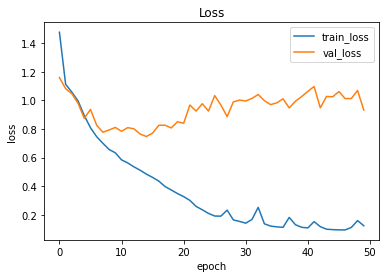

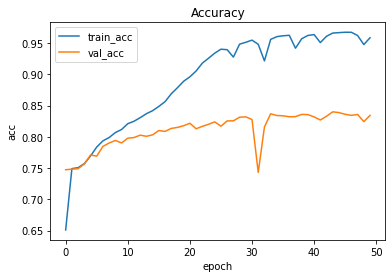

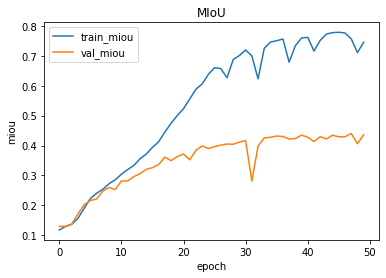

In [35]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [8]:
best=torch.load('./models/FCN8-Vgg16.pt')

In [9]:
def decode_segmap(image, num_class=21):
    label_color = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_class):
        idx = image==l
        r[idx] = label_color[l,0]
        g[idx] = label_color[l,1]
        b[idx] = label_color[l,2]
    rgb =np.stack([r,g,b], axis=2)
    return rgb

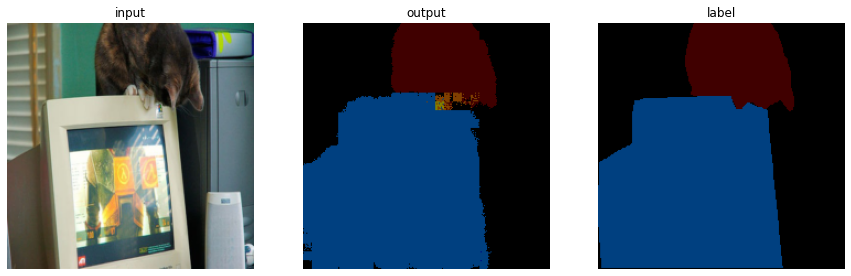

In [18]:
#img, label= train_set[0]
best.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        img, label = data
        
        best.to(device)
        #print(f'input shape:',img.shape)
        img = img.to(device)
        output = best(img)

        # tensor의 추적 제거 detach
        pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        pred = decode_segmap(pred,21)
        
        img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
        img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
        img = img[0].detach().cpu().numpy()
        img = img.transpose(1,2,0)

        label = label[0].detach().cpu().numpy()
        label = decode_segmap(label,21)

        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.title('input')
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('output')
        plt.axis('off')
        plt.imshow(pred)
        plt.subplot(1,3,3)
        plt.title('label')
        plt.axis('off')
        plt.imshow(label)
        break


torch.Size([1, 3, 224, 224])


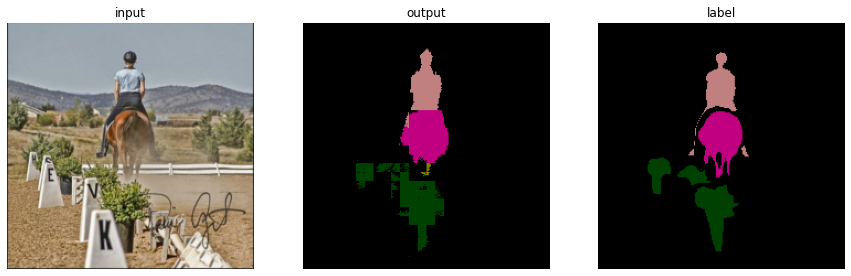

In [16]:
img, label= train_set[10]
best.eval()
#img = transform(img)
#label = val_transform(label)
best.to(device)
img=img.to(device)
label = label.to(device)
with torch.no_grad():
    
    img = img.unsqueeze(0)
    label = label.unsqueeze(0)
    output = best(img)
    pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        
    pred = decode_segmap(pred,21)
    print(img.shape)
    img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
    img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
    img = img.detach().cpu().numpy()
    img = img.transpose(1,2,0)
    label = label[0].detach().cpu().numpy()
    label = decode_segmap(label,21)
    
    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.title('input')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('output')
    plt.axis('off')
    plt.imshow(pred)
    plt.subplot(1,3,3)
    plt.title('label')
    plt.axis('off')
    plt.imshow(label)
    #break